In [1]:
import os
import PIL.Image as piImg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mp
import shutil

In [2]:
url = 'C:\\Users\\User\\Desktop\\cat_skin'

In [3]:
train_dir = os.path.join(url, 'train')
val_dir = os.path.join(url, 'val')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_importer = train_datagen.flow_from_directory(
    url+'\\train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data_importer = train_datagen.flow_from_directory(
    url+'/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2704 images belonging to 2 classes.
Found 680 images belonging to 2 classes.


In [11]:
#Resnet 모델 직접 작성
import tensorflow as tf
from tensorflow.keras import layers, models

def identity_block(input_tensor, filters, kernel_size):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, kernel_size, strides=(2, 2)):
    filters1, filters2, filters3 = filters

    x = layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal')(input_tensor)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def resnet50():
    input = layers.Input(shape=(224, 224, 3))
    x = layers.ZeroPadding2D((3, 3))(input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = conv_block(x, [64, 64, 256], (3, 3), strides=(1, 1))
    x = identity_block(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))

    x = conv_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))

    x = conv_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))

    x = conv_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs=input, outputs=x)
    return model

model = resnet50()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │      9,472 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_50[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_51[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

In [13]:
import os

model_dir = './model'
os.mkdir(model_dir)

FileExistsError: [WinError 183] 파일이 이미 있으므로 만들 수 없습니다: './model'

In [15]:
#model 저장 및 callback함수 설정
modelpath = './model/{epoch:02d}-{val_accuracy:.2f}.keras'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
hist = model.fit(
    train_data_importer,
    epochs=25,
    validation_data=val_data_importer,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/25


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7004 - loss: 1.1294
Epoch 1: val_loss improved from inf to 216.96338, saving model to ./model/01-0.74.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 516s 6s/step - accuracy: 0.7006 - loss: 1.1254 - val_accuracy: 0.7353 - val_loss: 216.9634
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7304 - loss: 0.5911
Epoch 2: val_loss improved from 216.96338 to 0.70273, saving model to ./model/02-0.70.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 492s 6s/step - accuracy: 0.7305 - loss: 0.5911 - val_accuracy: 0.6956 - val_loss: 0.7027
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7338 - loss: 0.5538
Epoch 3: val_loss did not improve from 0.70273
85/85 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.7339 - loss: 0.5537 - val_accuracy: 0.6353 - val_loss: 3.4104
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7529 - loss: 0.5220
Epoch 4: val_loss did not improve from 0.70273
85/85 ━━━━━━━━━━━━━━━━━━━━ 493s 6s/step - accuracy: 0.7

In [14]:
#학습된 Resnet 모델 임포트
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(4, activation='softmax') 
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
hist = model.fit(
    train_data_importer,
    epochs=25,
    validation_data=val_data_importer,
    callbacks=[checkpointer, early_stopping]
)

Epoch 1/25


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4123 - loss: 1.6091
Epoch 1: val_loss improved from inf to 80.80155, saving model to ./model/01-80.8016.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 522s 6s/step - accuracy: 0.4127 - loss: 1.6053 - val_accuracy: 0.2500 - val_loss: 80.8016
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5151 - loss: 1.1088
Epoch 2: val_loss improved from 80.80155 to 1.71592, saving model to ./model/02-1.7159.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 494s 6s/step - accuracy: 0.5151 - loss: 1.1085 - val_accuracy: 0.2500 - val_loss: 1.7159
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5818 - loss: 0.9700
Epoch 3: val_loss improved from 1.71592 to 1.42083, saving model to ./model/03-1.4208.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 494s 6s/step - accuracy: 0.5818 - loss: 0.9700 - val_accuracy: 0.2500 - val_loss: 1.4208
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6169 - loss: 0.9165
Epoch 4: val_loss did not improve from 1.42083
85/85 ━━

In [9]:
modelpath = './model/{epoch:02d}-{val_accuracy:.2f}.keras'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

NameError: name 'ModelCheckpoint' is not defined

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
hist = model.fit(
    train_data_importer,
    epochs=25,
    validation_data=val_data_importer,
    callbacks=[checkpointer, early_stopping]
)

NameError: name 'checkpointer' is not defined

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


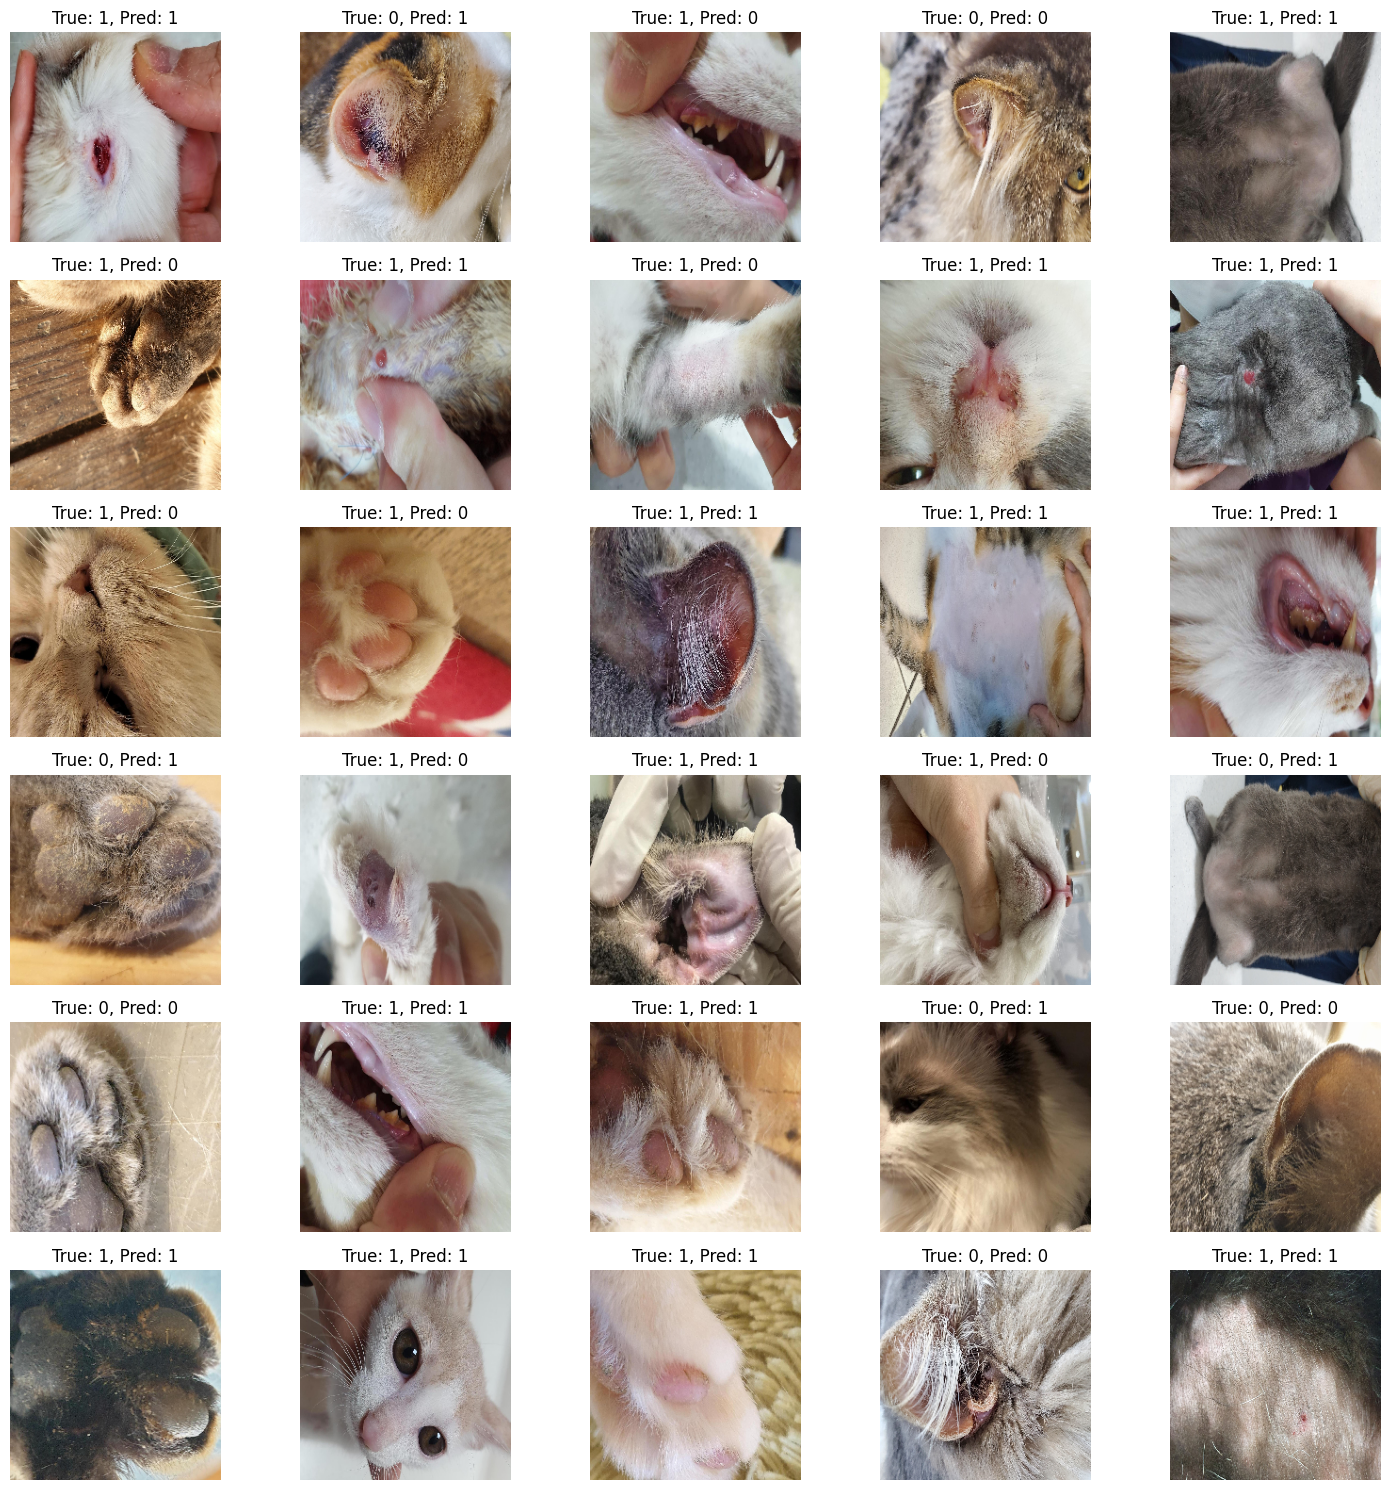

In [47]:
def plot_predictions(model, data_iterator, num_images=30, images_per_row=5):
    num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 15))
    
    images, labels = data_iterator[0]
    predictions = model.predict(images)
    
    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        ax = axes[row, col]
        
        image = (images[i] * 255).astype("uint8")
        ax.imshow(image)
        ax.set_title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[i])}")
        ax.axis("off")
    
    for j in range(num_images, num_rows * images_per_row):
        row = j // images_per_row
        col = j % images_per_row
        axes[row, col].axis("off")
    
    plt.tight_layout()
    plt.show()
plot_predictions(model, val_data_importer)